# Outlier Analysis
### Gavin Rolls

This notebook details the work done to a) identify outliers from the POI-only models run in the Modelling notebook and b) Understand how those locations might differ from other LSOAs

### Library Imports

In [330]:
#Basics
import pandas as pd
import geopandas as gpd
import numpy as np

#Plots and Stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Geometry
from shapely import wkt
from shapely.wkt import loads
from shapely.geometry import Polygon, MultiPolygon

### Data Loading

In [9]:
# London & Birmingham All Data

all_data_london = pd.read_csv("data/combined_data/lag/all_data_london_lag.csv")
all_data_bham = pd.read_csv("data/combined_data/lag/all_data_bham_lag.csv")

In [350]:
# LSOA Atlas Features

lsoa_atlas = pd.read_csv("data/lsoa_data/lsoa_atlas_preprocessed.csv", header = None)

#Condense Header into One
header_row1 = lsoa_atlas.iloc[0].astype(str)
header_row2 = lsoa_atlas.iloc[1].astype(str)

new_header = header_row1 + ' ' + header_row2
lsoa_atlas.columns = new_header
lsoa_atlas = lsoa_atlas[2:]

lsoa_atlas.rename(columns={'nan Codes': 'LSOA11CD', 'nan Names': 'LSOA11NM'}, inplace=True)

census_year_columns = [col for col in lsoa_atlas.columns if col.endswith('2011')]

# Create a new DataFrame with only the last year columns
lsoa_atlas_last_year = lsoa_atlas[['LSOA11CD', 'LSOA11NM'] + census_year_columns]

# Reset index
lsoa_atlas.reset_index(drop=True, inplace=True)

lsoa_atlas.head()

LSOA11CD     LSOA11NM All Ages 2013 Aged 0-15 2013 Aged 16-29 2013  \
0  E01000907  Camden 001A          1466            329             215   
1  E01000908  Camden 001B          1647            344             239   
2  E01000909  Camden 001C          1642            252             271   
3  E01000912  Camden 001D          1653            274             380   
4  E01000913  Camden 001E          1827            337             232   

  Aged 30-44 2013 Aged 45-64 2013 Aged 65+ 2013 Working-age 2013  \
0             389             354           179              958   
1             404             431           229             1074   
2             344             453           322             1068   
3             352             406           241             1138   
4             349             496           413             1077   

  Area (Hectares) nan  ...  \
0                10.7  ...   
1                17.5  ...   
2                22.9  ...   
3                89.6  ...   
4               161.7  ...   

  Whole house or bungalow: Terraced (including end-terrace) 2011  \
0                                                 97               
1                                                 33               
2                                                 64               
3                                                 71               
4                                                123               

  Flat, maisonette or apartment 2011  \
0                                493   
1                                739   
2                                391   
3                                619   
4                                365   

  Household spaces with at least one usual resident (%) 2011  \
0                                               99.5           
1                                               95.2           
2                                               97.6           
3                                               98.6           
4                                               89.7           

  Household spaces with no usual residents (%) 2011  \
0                                               0.5   
1                                               4.8   
2                                               2.4   
3                                               1.4   
4                                              10.3   

  Whole house or bungalow: Detached (%) 2011  \
0                                        2.2   
1                                        1.7   
2                                       11.7   
3                                          1   
4                                       27.1   

  Whole house or bungalow: Semi-detached (%) 2011  \
0                                             4.1   
1                                             9.4   
2                                            21.1   
3                                             1.8   
4                                            12.3   

  Whole house or bungalow: Terraced (including end-terrace) (%) 2011  \
0                                               15.4                   
1                                                3.8                   
2                                                9.5                   
3                                                 10                   
4                                               15.3                   

  Flat, maisonette or apartment (%) 2011 Median Price (£) 2014 Sales 2014  
0                                   78.3                568500         26  
1                                     85                350000         22  
2                                   57.8               1412500         16  
3                                   87.2                725000         11  
4                                   45.3                996585         33  

[5 rows x 84 columns]

In [302]:
# POI Modelling Results (Models 19 + 20)

london_model = pd.read_csv("data/combined_data/model_results_london_poi.csv", index_col=0)
bham_model = pd.read_csv("data/combined_data/model_results_bham_poi.csv", index_col=0)

# Convert Geometry col to make GeoDataFrame
london_model['geometry'] = london_model['geometry'].apply(loads)
london_model = gpd.GeoDataFrame(london_model, crs='EPSG:4326', geometry = london_model['geometry'])

bham_model['geometry'] = bham_model['geometry'].apply(loads)
bham_model = gpd.GeoDataFrame(bham_model, crs='EPSG:4326', geometry = bham_model['geometry'])

london_model.head()

name                                           geometry  observed  \
0  E01000034  POLYGON ((0.17380 51.56013, 0.17379 51.56012, ...  6.565265   
1  E01000035  POLYGON ((0.16598 51.55250, 0.16601 51.55248, ...  8.355850   
2  E01000036  POLYGON ((0.15965 51.54776, 0.15974 51.54771, ...  5.768321   
3  E01000037  POLYGON ((0.18508 51.56480, 0.18476 51.56454, ...  5.323010   
4  E01000038  POLYGON ((0.17599 51.56476, 0.17601 51.56475, ...  5.686975   

   predicted  
0   5.057694  
1   7.893040  
2   6.039518  
3   5.086926  
4   5.234150

In [306]:
# Select Outliers - Z score over or under 3

# Create residual column (predicted - actual)
london_model['residual'] = london_model['observed'] - london_model['predicted']
bham_model['residual'] = bham_model['observed'] - bham_model['predicted']

bham_model.head()


name                                           geometry  observed  \
0  E01008881  POLYGON ((-1.80957 52.47014, -1.80953 52.47009...  6.120297   
1  E01008882  POLYGON ((-1.82792 52.46893, -1.82768 52.46891...  3.401197   
2  E01008883  POLYGON ((-1.82144 52.46633, -1.82143 52.46632...  7.501082   
3  E01008884  POLYGON ((-1.82576 52.46527, -1.82579 52.46516...  7.859413   
4  E01008885  POLYGON ((-1.80450 52.46160, -1.80414 52.46135...  4.499810   

   predicted  residual  
0   6.563520 -0.443222  
1   3.956987 -0.555790  
2   6.655694  0.845388  
3   7.994729 -0.135315  
4   4.552658 -0.052848

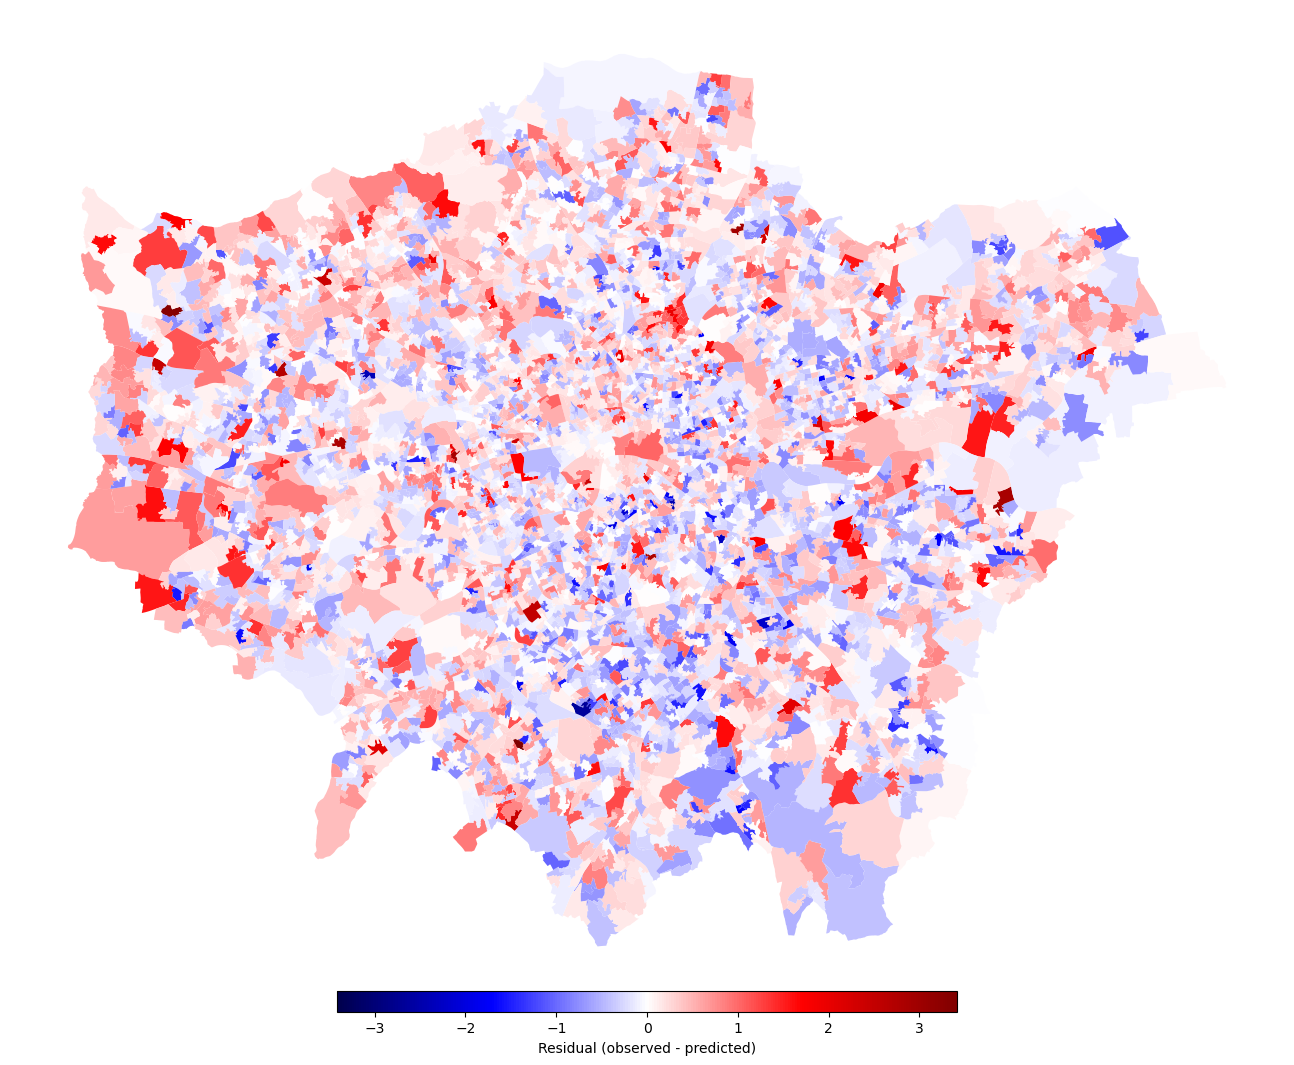

In [308]:
# Plot Residuals London (log)

vmax = max(abs(london_model['residual'].max()), abs(london_model['residual'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
london_model.plot(ax=ax, column='residual', linewidth=0, legend = True, cmap='seismic',
                      vmin=-vmax, vmax=vmax,
                     legend_kwds = {
                         'label': "Residual (observed - predicted)",
                        'orientation': "horizontal",
                        'pad' : 0.00,
                        'shrink': 0.4,
                        'aspect': 30})

ax.set_axis_off()
plt.show()

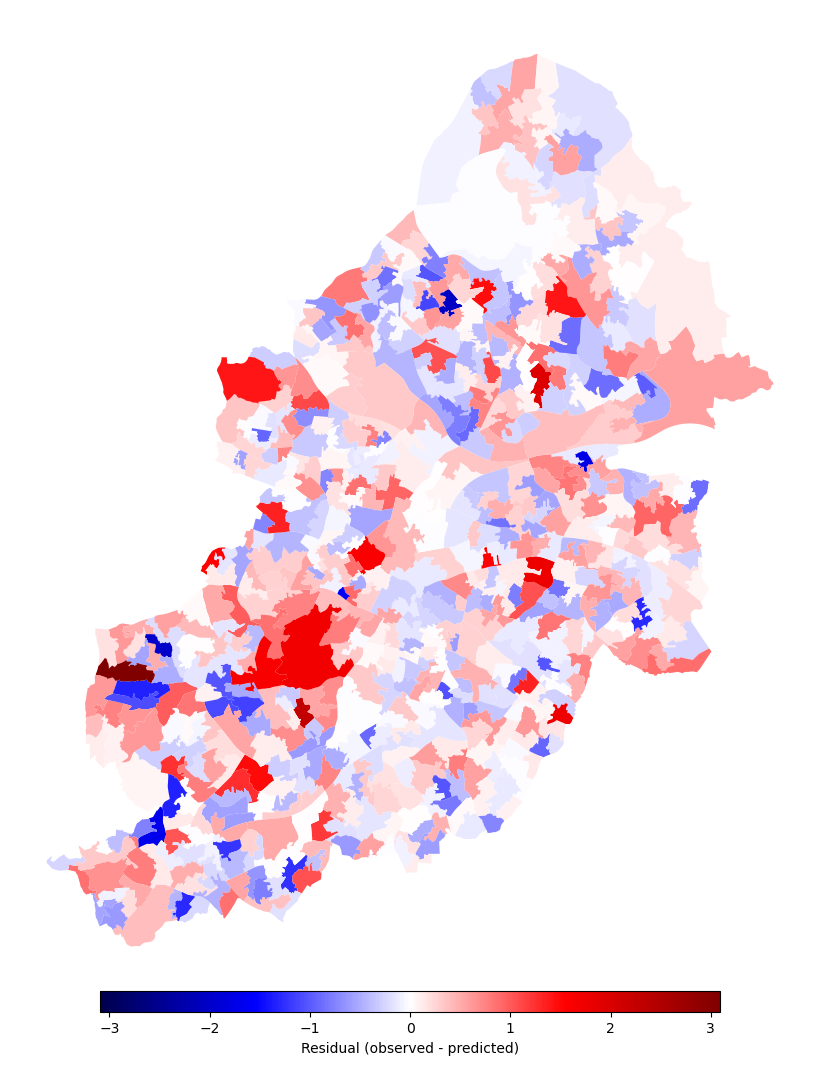

In [310]:
# Plot Residuals Birmingham (log)

vmax = max(abs(bham_model['residual'].max()), abs(bham_model['residual'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
bham_model.plot(ax=ax, column='residual', linewidth=0, legend = True, cmap='seismic',
                      vmin=-vmax, vmax=vmax,
                     legend_kwds = {
                         'label': "Residual (observed - predicted)",
                        'orientation': "horizontal",
                        'pad' : 0.00,
                        'shrink': 0.4,
                        'aspect': 30})

ax.set_axis_off()
plt.show()

In [312]:
# Underpredicted London

# Underpredicted threshold
condition = (london_model['residual'] > 1.5)
london_model['underpredicted'] = np.where(condition, london_model['residual'], 0)

vmax = max(abs(london_model['underpredicted'].max()), abs(london_model['underpredicted'].min()))

cmap_outliers = plt.cm.get_cmap('seismic')

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
london_model.plot(ax=ax, column='underpredicted', linewidth=0.1, edgecolor='black', legend = False, cmap=cmap_outliers, vmin=-vmax, vmax=vmax)

ax.set_axis_off()
plt.show()

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_58478/1576936941.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_outliers = plt.cm.get_cmap('seismic')


In [313]:
# Overpredicted London

# Overpredicted threshold
condition = (london_model['residual'] < -1.5)
london_model['overpredicted'] = np.where(condition, london_model['residual'], 0)

vmax = max(abs(london_model['underpredicted'].max()), abs(london_model['underpredicted'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
london_model.plot(ax=ax, column='overpredicted', linewidth=0.1, edgecolor='black', legend = False, cmap=cmap_outliers, vmin=-vmax, vmax=vmax)

ax.set_axis_off()
plt.show()

In [318]:
# Underpredicted Birmingham

# Underpredicted threshold
condition = (bham_model['residual'] > 1.5)
bham_model['underpredicted'] = np.where(condition, bham_model['residual'], 0)

vmax = max(abs(bham_model['underpredicted'].max()), abs(bham_model['underpredicted'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
bham_model.plot(ax=ax, column='underpredicted', linewidth=0.1, edgecolor='black', legend = False, cmap=cmap_outliers, vmin=-vmax, vmax=vmax)


ax.set_axis_off()
plt.show()

In [320]:
# Overpredicted Birmingham

# Overpredicted threshold
condition = (bham_model['residual'] < -1.5)
bham_model['overpredicted'] = np.where(condition, bham_model['residual'], 0)

vmax = max(abs(bham_model['overpredicted'].max()), abs(bham_model['overpredicted'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
bham_model.plot(ax=ax, column='overpredicted', linewidth=0.1, edgecolor='black', legend = False, cmap=cmap_outliers, vmin=-vmax, vmax=vmax)

ax.set_axis_off()
plt.show()

In [362]:
# Feature Analysis of Outliers

# Create new dataframes with over and underpredicted LSOAS only
london_underpredicted = london_model[london_model['underpredicted'] != 0].copy()
london_overpredicted = london_model[london_model['overpredicted'] != 0].copy()

bham_underpredicted = bham_model[bham_model['underpredicted'] != 0].copy()
bham_overpredicted = bham_model[bham_model['overpredicted'] != 0].copy()

# Convert LSOA atlas data to numeric
columns_to_convert = lsoa_atlas.columns[2:]
lsoa_atlas[columns_to_convert] = lsoa_atlas[columns_to_convert].apply(pd.to_numeric, errors="coerce")

# Join all London on LSOA atlas

london_underpredicted_stats = pd.merge(lsoa_atlas, london_underpredicted[['name']], left_on='LSOA11CD', right_on='name', how='inner')
london_overpredicted_stats = pd.merge(lsoa_atlas, london_overpredicted[['name']], left_on='LSOA11CD', right_on='name', how='inner')

# And remainders (for T-test)
london_underpredicted_remainder = lsoa_atlas[~lsoa_atlas['LSOA11CD'].isin(london_underpredicted_stats['LSOA11CD'])]
london_overpredicted_remainder = lsoa_atlas[~lsoa_atlas['LSOA11CD'].isin(london_overpredicted_stats['LSOA11CD'])]

london_underpredicted_stats.head()

LSOA11CD      LSOA11NM  All Ages 2013  Aged 0-15 2013  Aged 16-29 2013  \
0  E01000962   Camden 016A           1699             245              373   
1  E01001814  Hackney 001C           1763             534              387   
2  E01001804  Hackney 003C           1559             530              316   
3  E01001826  Hackney 004E           1813             642              384   
4  E01001727  Hackney 006C           1994             665              417   

   Aged 30-44 2013  Aged 45-64 2013  Aged 65+ 2013  Working-age 2013  \
0              695              267            119              1335   
1              452              277            113              1116   
2              349              232            132               897   
3              386              267            134              1037   
4              494              295            123              1206   

   Area (Hectares) nan  ...  Flat, maisonette or apartment 2011  \
0                  9.5  ...                                 719   
1                 11.4  ...                                 362   
2                 11.1  ...                                 332   
3                 11.3  ...                                 440   
4                 10.7  ...                                 365   

   Household spaces with at least one usual resident (%) 2011  \
0                                               96.4            
1                                               96.5            
2                                               97.1            
3                                               98.0            
4                                               95.0            

   Household spaces with no usual residents (%) 2011  \
0                                                3.6   
1                                                3.5   
2                                                2.9   
3                                                2.0   
4                                                5.0   

   Whole house or bungalow: Detached (%) 2011  \
0                                         0.9   
1                                         3.6   
2                                         1.9   
3                                         2.3   
4                                         3.6   

   Whole house or bungalow: Semi-detached (%) 2011  \
0                                              1.4   
1                                              5.9   
2                                             17.6   
3                                              7.2   
4                                              9.0   

   Whole house or bungalow: Terraced (including end-terrace) (%) 2011  \
0                                                4.7                    
1                                               28.0                    
2                                               11.1                    
3                                               16.8                    
4                                               26.9                    

   Flat, maisonette or apartment (%) 2011  Median Price (£) 2014  Sales 2014  \
0                                    93.0               740500.0          35   
1                                    62.5               265000.0           7   
2                                    69.5               400000.0          10   
3                                    73.7               342500.0           6   
4                                    60.5               527500.0           4   

        name  
0  E01000962  
1  E01001814  
2  E01001804  
3  E01001826  
4  E01001727  

[5 rows x 85 columns]

In [416]:
# T-Test Analysis on LSOA Categories

# Get features (all columns in preprocessed atlas)
features = lsoa_atlas.columns[2:-1]

# T-Test calculations

results = {}
t_results = []

for feature in features:
    stat_underpredicted, pval_underpredicted = stats.ttest_ind(london_underpredicted_stats[feature], london_underpredicted_remainder[feature])
    stat_overpredicted, pval_overpredicted = stats.ttest_ind(london_overpredicted_stats[feature], london_overpredicted_remainder[feature])
    
    results[feature] = {
        'Underpredicted': {'t-statistic': stat_underpredicted, 'p-value': pval_underpredicted},
        'Overpredicted': {'t-statistic': stat_overpredicted, 'p-value': pval_overpredicted}
    }

    t_results.append({
        'Feature': feature,
        'Underpredicted_t-statistic': stat_underpredicted,
        'Underpredicted_p-value': pval_underpredicted,
        'Overpredicted_t-statistic': stat_overpredicted,
        'Overpredicted_p-value': pval_overpredicted
    })

# Print results
for feature, result in results.items():
    print(f"Feature: {feature}")
    print("Underpredicted vs Remainder:")
    print(f"T-statistic: {result['Underpredicted']['t-statistic']}")
    print(f"P-value: {result['Underpredicted']['p-value']}")
    if result['Underpredicted']['p-value'] < 0.05:
        print("There is a significant difference between the means.")
    else:
        print("There is no significant difference between the means.")
    
    print("\nOverpredicted vs Remainder:")
    print(f"T-statistic: {result['Overpredicted']['t-statistic']}")
    print(f"P-value: {result['Overpredicted']['p-value']}")
    if result['Overpredicted']['p-value'] < 0.05:
        print("There is a significant difference between the means.")
    else:
        print("There is no significant difference between the means.")
    
    print()

1               387              452              277            113   
Feature: All Ages 2013
Underpredicted vs Remainder:
T-statistic: -2.321790306158639
P-value: 0.02028559096242362
There is a significant difference between the means.

Overpredicted vs Remainder:
T-statistic: -2.5935973766238165
P-value: 0.009526414848003137
There is a significant difference between the means.

Feature: Aged 0-15 2013
Underpredicted vs Remainder:
T-statistic: 0.17484967517807137
P-value: 0.8612050785091597
There is no significant difference between the means.

Overpredicted vs Remainder:
T-statistic: 2.5432061258446748
P-value: 0.011014943951457972
There is a significant difference between the means.

Feature: Aged 16-29 2013
Underpredicted vs Remainder:
T-statistic: -0.15804762455490673
P-value: 0.8744258741524491
There is no significant difference between the means.

Overpredicted vs Remainder:
T-statistic: 0.020381987830390524
P-value: 0.983739493868999
There is no significant difference between 

In [424]:
# Process results dataframe
t_results = pd.DataFrame(t_results)

# Sort (under & overpredicted)
t_results_underpredicted = t_results.sort_values(by='Underpredicted_p-value')
t_results_overpredicted = t_results.sort_values(by='Overpredicted_p-value')


t_results_underpredicted.head(10)

Feature  \
37  Households with at least one person aged 16 or...   
68  Household spaces with at least one usual resid...   
10                                All households 2011   
67                                All Households 2011   
53                                    Jewish (%) 2011   
44                                        Jewish 2011   
12   Couple household without dependent children 2011   
4                                     Aged 45-64 2013   
60                 Owned with a mortgage or loan 2011   
48                                   No religion 2011   

    Underpredicted_t-statistic  Underpredicted_p-value  \
37                   -4.032437                0.000056   
68                   -4.013008                0.000061   
10                   -4.013008                0.000061   
67                   -3.564636                0.000368   
53                    3.413447                0.000647   
44                    3.411130                0.000652   
12                   -3.336820                0.000854   
4                    -2.973496                0.002959   
60                   -2.870560                0.004115   
48                   -2.776728                0.005512   

    Overpredicted_t-statistic  Overpredicted_p-value  
37                  -3.080179           2.080388e-03  
68                  -2.922094           3.492978e-03  
10                  -2.922094           3.492978e-03  
67                  -3.234190           1.228088e-03  
53                  -1.730469           8.361041e-02  
44                  -1.707044           8.787805e-02  
12                  -6.973511           3.508034e-12  
4                   -3.697110           2.204857e-04  
60                  -5.874645           4.521349e-09  
48                  -0.787739           4.308877e-01

In [426]:
t_results_overpredicted.head(10)

Feature  \
65                             Social rented (%) 2011   
18                       % Lone parent household 2011   
30     Black/African/Caribbean/Black British (%) 2011   
12   Couple household without dependent children 2011   
61                                 Social rented 2011   
13                         Lone parent household 2011   
59                                Owned outright 2011   
8                            Persons per hectare 2012   
17  % Couple household without dependent children ...   
9                            Persons per hectare 2013   

    Underpredicted_t-statistic  Underpredicted_p-value  \
65                    1.488384                0.136715   
18                    1.465905                0.142739   
30                    0.992359                0.321072   
12                   -3.336820                0.000854   
61                    0.324777                0.745364   
13                   -0.444401                0.656772   
59                   -2.482907                0.013065   
8                    -0.262895                0.792643   
17                   -1.236263                0.216421   
9                    -0.320983                0.748238   

    Overpredicted_t-statistic  Overpredicted_p-value  
65                   8.763448           2.581180e-18  
18                   8.600136           1.061605e-17  
30                   7.165961           8.891118e-13  
12                  -6.973511           3.508034e-12  
61                   6.834568           9.245367e-12  
13                   6.474401           1.046376e-10  
59                  -6.429312           1.405494e-10  
8                    6.043802           1.618259e-09  
17                  -5.915760           3.531013e-09  
9                    5.905940           3.746341e-09